##### Copyright 2018 The TensorFlow Authors.

##### Modifications Copyright 2019 Tomoaki Masuda.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

このノートブックは、以下のノートブックを元に日本語訳、一部章立ての再構成、加筆を行いました。https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb


# 映画情報サイトにあるレビューを識別する



このノートブックは、映画レビューの文章を、*ポジティブな評価*か*ネガティブな評価*かの二種類に分類します。これは、二項分類や二クラス分類と呼ばれ、重要かつ幅広く使える機械学習のタスクのひとつです。 

 [Internet Movie Database](https://www.imdb.com/)から5万の映画レビュー文章を集めたデータセットである、[IMDBデータセット](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb)を使います。これは学習用2万5千レビューとテスト用2万5千レビューに分けられます。学習セットとテストセットはポジティブ、ネガティブ同数のレビューが含まれます（balanced）。 

このノートブックはTensorFlowでモデルを構築し学習するための高レベルAPI [tf.keras](https://www.tensorflow.org/guide/keras)を使います。 `tf.keras`を使用したより高度なテキスト分類チュートリアルは、 [MLCCテキスト分類ガイド](https://developers.google.com/machine-learning/guides/text-classification/)を参照してください。 



## A. 環境を準備する

必要なライブラリのインストール、インポートを行います。

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.13.1



## B. データセットを準備する


### 1. IMDBデータセットをダウンロードする

 IMDBデータセットはTensorFlowに同梱されています。レビュー（単語の並び）が整数の並びに変換されるよう、すでに前処理されています。各整数は辞書内の特定の単語を表します。 

次のコードで、IMDBデータセットをダウンロードします（すでにダウンロード済みの場合はキャッシュコピーを使用します）。 


In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 1s 0us/step



引数`num_words=10000`で、学習データセット中、最も頻繁に出現する上位1万語のみ保持するよう指定します。データのサイズが大きくなり過ぎないよう、あまり出てこない単語は破棄されます。 



### 2. データセットの中身を見てみる

少し時間をかけて、データのフォーマットを理解しましょう。データセットは前処理されています。各例は、映画レビューの単語を表す整数の並び（配列）です。各ラベルは0または1の整数値です。0は否定的なレビュー、1は肯定的なレビューを表します。 


In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000



レビューのテキストは整数に変換され、各整数は辞書内にある単語を表します。最初のレビューは次のようになります。 


In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]



映画のレビュー文は、それぞれ長さが異なります。以下のコードで、最初のレビューと2番目のレビューの単語数を確認してみましょう。一般に、ニューラルネットワークへの入力は同じ長さである必要があります。後でこの問題を解決しましょう。


In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)


### 3. 整数を単語に戻す

整数をテキストに変換して戻す方法を知っておくと便利です。ここでは、整数から文字列への対応づけを持つ辞書オブジェクトへ、問い合わせをするためのヘルパー関数を作ります。 


In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1654784/1641221 [==============================] - 0s 0us/step



これで`decode_review`関数を使って最初のレビューのテキストを表示することができます。 


In [7]:
decode_review(train_data[0])

u"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for w


## C. データセットを前処理する

レビュー（整数の配列）は、ニューラルネットワークへ入力する前にテンソルに変換します。変換には、いくつか方法があります。 

- ワンホットエンコーディングと同様、配列を単語の出現を示す0と1のベクトルに変換します。たとえば、シーケンス `[3、5]` は、1であるインデックス3と5を除いて、すべて0の1万次元ベクトルになります。次に、これをネットワークの最初の層、つまり、浮動小数点のベクトルデータを処理できる全結合層にします。ただし、この方法では大量のメモリが必要です。 `num_words * num_reviews`の形をもつ行列を保持するからです。 
- 代わりに、すべて同じ長さになるように配列をパディングしてから、`max_length * num_reviews`の形をもつ整数テンソルを作成することもできます。この形状を処理できるembedding層をネットワークの最初の層として使います。

このチュートリアルでは、後者を使います。 

入力の映画レビューを同じ長さである必要があるので、 [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)関数を使い、長さを標準化します。 


In [ ]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)


例の長さを見てみましょう。 


In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)


そして、（今はパディングされた）最初のレビューを調べます。 


In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 


## D. モデルを作成する

ニューラルネットワークは、レイヤを連ねる、または重ねて作ります。構造（アーキテクチャ）を決める、2つ重要なポイントがあります。

- モデルにいくつのレイヤを使うか？
- 各層にいくつの*ノード*を使うか？ 

この例では、入力は単語インデックスの配列です。出力される予測ラベルは0か1のいずれかです。この課題を解くモデルを作りましょう。 


In [11]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________



これらの層を順番に積み重ねて分類器を作ります。

1. 最初の層は`Embedding`層です。この層は整数で表された単語を取り、各単語のインデックスに対応した単語の埋め込みベクトル（または、単語の分散表現）を返します。これらの埋め込みベクトルも、モデルの学習が進むのと同時に、学習が進みます。ベクトルは出力配列に次元を追加します。結果得られる次元は`(batch, sequence, embedding)`です。 
1. 次に、 `GlobalAveragePooling1D`レイヤは、シーケンスにある単語毎の埋め込みベクトルの各次元を、単語横断で平均をとることで、各レビューに対応する固定長出力ベクトルを返します。これで、モデルは可変長の入力を固定長として扱えるようになります。平均を取るのは、考えうる限り一番簡単な方法でしょう。 
1. この固定長出力ベクトルは、16個のノードを持つ全結合層（ `Dense` ）を通り、処理されます。 
1. 最終層の単一の出力ノードとは、全結合で接続されます。 `sigmoid`を活性化関数として使い、出力ノードの値は0から1の間の浮動小数点数(float型)として、確率、または確信度を表します。 



### 1. ノード（隠れユニット）


上記のモデルには、入力と出力の間に2つの中間層（または、隠れ層）があります。出力数（ユニット、ノード、またはニューロンと呼びます）は、レイヤが表現できる空間の次元です。言い換えると、内部表現を学習するときにネットワークが許容する自由度です。 

モデルがより多くのノード（高次元の表現空間）やレイヤを持つと、ネットワークはより複雑な表現を学ぶことができます。しかし、同時にネットワークの計算コストが高くなり、不要なパターン（つまり学習データでの精度は向上するが、テストデータでの精度は向上しないパターン）の学習をしてしまうことがあります。これは*過学習*と呼ばれており、後で触れます。 



### 2. 損失関数とオプティマイザ

モデルには、損失関数と学習用のオプティマイザが必要です。今回の課題は、二項分類問題です。モデルは確率（活性化関数としてのSigmoid関数を含む単一層）を出力するので、 `binary_crossentropy` という損失関数を使います。 

損失関数は他にも選ぶことができます。例えば、 `mean_squared_error`が選べます。ただ一般に、 `binary_crossentropy`は、確率を扱うのに適しています。確率分布間、またはこの場合は正解データの分布と予測データの分布間の「距離」を測定します。 

後に回帰問題をみてゆくとき（たとえば家の価格を予測するとき）、平均二乗誤差と呼ばれる別の損失関数を使います。

次に、指定したオプティマイザと損失関数を使うよう、下の関数でモデルをコンパイルします。 


In [ ]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## E. モデルを学習させる


### 1. 検証データセットを準備する

学習中、モデルの精度を未知のデータで確認します（検証、Validation）。そのため、元の学習データから10,000個の例を分けて、*検証データセット*を準備します。

なぜ今テストデータセットを使わないのでしょうか？なぜなら、学習データのみを使用してモデルを学習・調整し、その間に検証データセットを使います。そして、次にテストデータを1回だけ使用して精度を評価したいからです。 


In [ ]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]


### 2. モデルを学習させる

 512サンプルのミニバッチで40エポック、モデルを学習させます。これは、`x_train`と`y_train`テンソルの全サンプルを、40回繰り返し使って学習します。学習中に、検証セットからの1万サンプルでモデルの誤差(loss)と精度を監視します。 


In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 2s 102us/sample - loss: 0.6912 - acc: 0.5622 - val_loss: 0.6885 - val_acc: 0.6330
Epoch 2/40
15000/15000 [==============================] - 1s 64us/sample - loss: 0.6834 - acc: 0.7144 - val_loss: 0.6782 - val_acc: 0.7389
Epoch 3/40
15000/15000 [==============================] - 1s 61us/sample - loss: 0.6676 - acc: 0.7596 - val_loss: 0.6589 - val_acc: 0.7664
Epoch 4/40
15000/15000 [==============================] - 1s 61us/sample - loss: 0.6412 - acc: 0.7755 - val_loss: 0.6293 - val_acc: 0.7717
Epoch 5/40
15000/15000 [==============================] - 1s 61us/sample - loss: 0.6035 - acc: 0.8057 - val_loss: 0.5907 - val_acc: 0.7964
Epoch 6/40
15000/15000 [==============================] - 1s 60us/sample - loss: 0.5574 - acc: 0.8243 - val_loss: 0.5472 - val_acc: 0.8109
Epoch 7/40
15000/15000 [==============================] - 1s 61us/s


## F. 学習済みモデルを評価する

学習したモデルの性能を見てみましょう。以下の2つの値が返されます。

- 誤差（私たちのエラーを表す数値、低い値の方が優れています）
- 精度 


In [15]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 38us/sample - loss: 0.3388 - acc: 0.8698
[0.3387693747806549, 0.86984]



このような、とても素朴なアプローチでも、約87％の精度を達成できました。より高度なアプローチでは、モデルは95％に近づくはずです。 



### 1. 精度と誤差(loss)の時系列グラフを作成する

 `model.fit()`は、学習中に起こったことすべてを含む辞書を含む`History`オブジェクトを返します。 


In [16]:
history_dict = history.history
history_dict.keys()

['acc', 'loss', 'val_acc', 'val_loss']


学習中の、以下4つの値の推移が保存されています。

- acc 学習データセットに対する精度
- loss　学習データセットに対する誤差
- val_acc　検証データセットに対する精度
- val_loss　検証データセットに対する誤差

学習および検証中に監視される各メトリックに1つです。これらを使って、比較のために学習・検証データセットの誤差、精度（正解率）をプロットできます。 


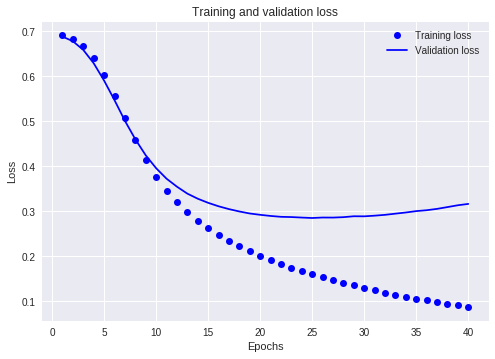

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

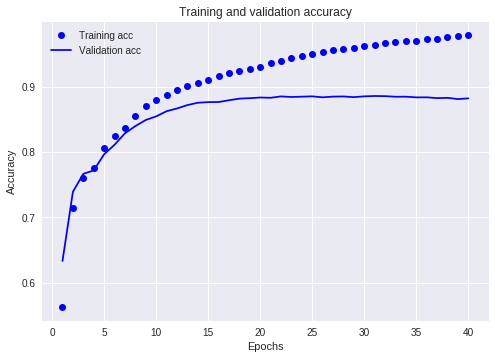

In [18]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


このプロットでは以下を表します。

- 点線は学習データセットの誤差と精度
- 実線は検証データセットの誤差と精度

学習時の誤差が各エポックで*減少*し、精度が各エポックで*増加*することに注目してください。これは、勾配降下法による最適化を使うと、見られる動きです。エポックを反復するごとに、誤差が最小になるよう、パラメータを調整していきます。 

しかし、検証データセットの誤差と精度には当てはまりません。約20エポックでピークに達したようです。これは過学習の兆候を示しています。モデルは、学習データセットに対して、未知のデータセットよりも優れた精度を示します。20エポックを超えると、モデルはテストデータに現れない、学習データセットに固有の表現を過度に最適化して学習してしまったようです。

このケースでは、20回程度のエポックの後、単にトレーニングを中止することで、過学習を防げます。コールバックを使って、学習の自動停止をする方法もあります。